***This is the implementation of the [Self-supervise, refine, repeat: improving unsupervised anomaly detection](https://openreview.net/pdf?id=Nct9j3BVswZ)
 paper in Pytorch.***

 In this notebook you will find the implementation of SSR for both contrastive and rotation losses and using as One Class Classifier OneClassSVM and also Gaussian Mixture + mahalanobis distance. You can apply it in 3 different datasets.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.svm import OneClassSVM
from sklearn.model_selection import StratifiedKFold
from sklearn.mixture import GaussianMixture

from torchvision.models import resnet18
import torch
from torch import nn
from torch import optim

from torch.utils.data import Dataset, DataLoader
from torch.backends import cudnn

import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import  SubsetRandomSampler 

device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

cuda


# Pre processing function and dataset classes

In [ ]:
#pre processing and dataset class

#pre processing and dataset class
def preprocess_dataset(data, label, nclasses, normal_class=0, abnormal_rate=0.1):
  out = []
  toPil = transforms.ToPILImage()
  for x, y in zip(data, label):
    if dataset == 'fmnist':
        x = toPil(x.repeat(3,1,1))
    elif dataset == 'cifar10':
        x = toPil(x)
    if y == normal_class:
      out.append((x, 0))
    else:
      if np.random.rand(1) < abnormal_rate/(nclasses-1):
        out.append((x, 1))

  return out

  class ContrastiveDataset(Dataset):
    def __init__(self, data, transform=None, contrastive = False):
        self.data = data   
        self.transform = transform
        self.contrastive = contrastive

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        
        if self.contrastive:
          img1 = self.transform(img)
          img2 = self.transform(img)
          return img1, img2

        return self.transform(img), label

class RotationDataset(Dataset):
    def __init__(self, data, rotate = False, transform=None):
        self.data = data   
        self.transform = transform
        self.rotate = rotate

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        
        if self.rotate:
          label = np.random.randint(4)
          img = torch.rot90(img, label)

        if self.transform:
            img = self.transform(img)

        return img, label

# Contrastive

Two different implementations of contrastive loss. 

In [ ]:
#contrastive loss implementation modified from https://github.com/HobbitLong/SupContrast/blob/master/losses.py and https://medium.com/the-owl/simclr-in-pytorch-5f290cb11dd7



class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features):
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        batch_size = features.shape[0]
        mask = torch.eye(batch_size, dtype=torch.float32).to(device)

        contrast_count = 2
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss


class NT_Xent(nn.Module):
    def __init__(self, temperature=0.07):
        super(NT_Xent, self).__init__()
        self.temperature = temperature

        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, features):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        batch_size = features.shape[0]
        N = 2 * batch_size

        z = torch.cat(torch.unbind(features, dim=1), dim=0)
        mask = self.mask_correlated_samples(batch_size)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, -batch_size)

        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        return loss

Contrastive model

In [ ]:
class PreModel(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        
        #PRETRAINED MODEL
        self.pretrained = resnet18(pretrained=False, num_classes=4 * hidden_dim)
        
        self.projectionHead = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim),
        )

    def forward(self,x):
        
        out = self.pretrained(x)
        out = self.projectionHead(out)
        
        return out

# OCC score

In [ ]:
def score_samples(data, occ):
    '''OCC has to be 1-component gaussian model'''
    #calculate Mahalanobis distance
    mahalanobis = []
    mu = occ.means_
    sigmainv = np.linalg.inv(occ.covariances_)

    for d in data:
      res = np.dot((d-mu), np.dot(sigmainv, (d-mu).T))
      mahalanobis.append(res)

    return np.asarray(mahalanobis)

# Training and feature extraction functions

Training function for both rotation and contrastive

In [ ]:
#Training functions
    

def train(model, data, criterion, optimizer, epoch):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),])
  
    data = RotationDataset(data, transform=transform)

    batch_size = 100
    train_loader = DataLoader(data, batch_size, drop_last=True)

    l, i=0, 0
    model.train()
    for i, (x, y) in enumerate(train_loader):
        x = x.float().to(device)
        y = y.to(device)
        
        yhat = model(x)
        loss = criterion(yhat, y)
        
        loss.backward()
        optimizer.step()
        
        l+=loss.item()

    del data
    del train_loader
        
    print("Epoch:", epoch+1, "self-supervised rotation loss:", l/i)
    return l/i

def extract_features(data, model):
  transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),])
  
  data = RotationDataset(data, transform=transform)
  
  batch_size = 100
  train_loader = DataLoader(data, batch_size, shuffle=False, drop_last=False)

  model.eval()
  out = []
  for inps, labs in train_loader:
      inps, labs = inps.float().to(device), labs.to(device)
      features = model.feature_extractor(inps).squeeze(2).squeeze(2)
      out.append(features)

  del data
  del train_loader
  
  #return the extracted features
  return torch.cat(out,dim=0).cpu().detach().numpy()
  
class ContrastiveDataset(Dataset):
    def __init__(self, data, transform=None, contrastive = False):
        self.data = data   
        self.transform = transform
        self.contrastive = contrastive

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        
        if self.contrastive:
          img1 = self.transform(img)
          img2 = self.transform(img)
          return img1, img2

        return self.transform(img), label

class RotationDataset(Dataset):
    def __init__(self, data, rotate = False, transform=None):
        self.data = data   
        self.transform = transform
        self.rotate = rotate

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        
        if self.rotate:
          label = np.random.randint(4)
          img = torch.rot90(img, label)

        if self.transform:
            img = self.transform(img)

        return img, label

def train_contrastive(model, data, criterion, optimizer, epoch):
    contrast_transforms = transforms.Compose(
      [
          transforms.RandomHorizontalFlip(),
          transforms.RandomResizedCrop(size=28),
          transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
          transforms.RandomGrayscale(p=0.2),
          transforms.GaussianBlur(kernel_size=9),
          transforms.ToTensor(),
          transforms.Normalize((0.5,), (0.5,)),
      ]
  )
    
    batch_size = 100
    data = ContrastiveDataset(data, transform=contrast_transforms, contrastive=True)
    
    train_loader = DataLoader(data, batch_size, drop_last=True)

    l, i=0, 0
    model.train()
    for i, (x1, x2) in enumerate(train_loader):
        x1 = x1.float().to(device)
        x2 = x2.float().to(device)
        
        y1 = model(x1).unsqueeze(1)
        y2 = model(x1).unsqueeze(1)

        y = torch.cat([y1,y2], dim=1)

        loss = criterion(y)
        
        loss.backward()
        optimizer.step()
        
        l+=loss.item()

    del data
    del train_loader
    
    print("Epoch:", epoch+1, "self-supervised contrastive loss:", l/i)
    return l/i

def extract_features_contrastive(data, model):
  transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),])
  
  batch_size = 100

  data = ContrastiveDataset(data, transform=transform, contrastive=False)

  
  train_loader = DataLoader(data, batch_size, shuffle=False, drop_last=False)

  model.eval()
  out = []
  for inps, labs in train_loader:
      inps, labs = inps.float().to(device), labs.to(device)
      features = model(inps).squeeze(1)
      out.append(features)

  del data
  del train_loader
  
  #return the extracted features
  return torch.cat(out,dim=0).cpu().detach().numpy()

# SSR algorithm

Implementation from the paper using Gaussian Mixture model as OCC

In [ ]:
# SSR algorithm

def refine_data(data, model, k, th, occ_type):
    if ss_type == 'rotation':
      data = extract_features(data, model)
    else:
      data = extract_features_contrastive(data, model)

    models = []

    #divide k sets
    total_idx = list(range(len(data)))
    np.random.shuffle(total_idx)
    indices = np.array_split(total_idx, k)
    nu = []
    #split the data
    for idx in indices:
        data_hat = data[idx]
        #train OCC for disjoint set k
        if occ_type == 'svm':
          occ = OneClassSVM(kernel='rbf', gamma=.01)
        else:
          occ = GaussianMixture(n_components=1, covariance_type="tied", reg_covar=1e-02)
        occ.fit(data_hat)
        #append the nu and the model
        if occ_type == 'svm':
          nu.append(np.quantile(-occ.score_samples(data_hat), th))
        else:
          nu.append(np.quantile(score_samples(data_hat, occ), th))
        models.append(occ)
    
    #actual threhshold nu is the maximum threhshold found
    nk = max(nu)

    y = np.zeros(len(data))
    for occ_act in models:
        #predict the score samples for each data point for each model
        if occ_type == 'svm':
          res = -occ.score_samples(data)
        else:
          res = score_samples(data, occ_act).squeeze(1).squeeze(1)
        res2 = res >= nk
        y += res2

    #if all models predicted as normal, it's a normal data point
    normal_idx = np.where(y == 0)[0]
    
    #return only the index of normal data to update the feature extractor
    return normal_idx

def SSR(data, k, th, model, nepochs=300, early_stopping=80, verbose=10, occ_type='svm'):
  
    best_loss = 100000
    es = 0

    for epoch in range(nepochs):
        #refined data, a.k.a. normal data points
        refined_data_idx = refine_data(data, model, k, th, occ_type)
        #just a trick to iterate over a tuple, can't just do data[refined_data_idx]
        data_to_train = [data[index] for index in refined_data_idx]
        #train the feature extractor
        print('--------------------------------------------------------------------')
        
        if ss_type == 'rotation':
          act_loss = train(model, data_to_train, criterion, optimizer, epoch)
        else:
          act_loss = train_contrastive(model, data_to_train, criterion, optimizer, epoch)

        es+=1
        #update best model weights
        if act_loss < best_loss:
          best_loss = act_loss
          es=0
          best_model_wts = copy.deepcopy(model.state_dict())

        if verbose!= 0 and epoch%verbose == 0:
          occ = GaussianMixture(n_components=1, covariance_type="tied", reg_covar=1e-02)
          if ss_type == 'rotation':
            data_to_train = extract_features(data_to_train, model)
          else:
            data_to_train = extract_features_contrastive(data_to_train, model)
          occ.fit(data_to_train)

          #Evaluate on train set
          print('Train evaluation')
          evaluate(model, occ, data)
          print('Test evaluation')
          evaluate(model, occ, testset_tuple)

        # Early stopping condition
        if es >= early_stopping:
            break

        del data_to_train
    
    #load the weights of the best epoch
    model.load_state_dict(best_model_wts)
    #train the final OCC with the refined data
    if occ_type=='svm':
      occ = OneClassSVM(kernel='rbf', gamma=.01)
    else:
      occ = GaussianMixture(n_components=1, covariance_type="tied", reg_covar=1e-02)
      
    refined_data_idx = refine_data(data, model, k, th, occ_type)
    data_to_extract = [data[index] for index in refined_data_idx]

    if ss_type == 'rotation':
      refined_data = extract_features(data_to_extract, model)
    else:
      refined_data = extract_features_contrastive(data_to_extract, model)

    occ.fit(refined_data)
    
    return refined_data_idx, occ, model

# Evaluation functions

In [ ]:
#Evaluation metrics

from sklearn import metrics

def anomaly_ratio_prediction(pred, data):
  nAnomalies = sum(pred)
  sNormals, sAnormals = 0, 0
  for i in range(len(pred)):
      if pred[i] == 1:
        if data[i][1] == 0:
          sNormals+=1
        else:
          sAnormals+=1

  removedNormalSamples, removedAnormalSamples = sNormals/nAnomalies, sAnormals/nAnomalies

  return removedNormalSamples, removedAnormalSamples

def average_precision(pred, data):
  y = []
  for i in range(len(pred)):
      y.append(data[i][1])

  return metrics.average_precision_score(y, pred)

def f1(pred, data):
  y = []
  for i in range(len(pred)):
      y.append(data[i][1])

  return metrics.f1_score(y, pred)

def auc(pred, data):
  y = []
  for i in range(len(pred)):
      y.append(data[i][1])

  fpr, tpr, thresholds = metrics.roc_curve(y, pred)

  return metrics.auc(fpr, tpr)



def evaluate(model, occ, data):
  if ss_type == 'rotation':
    extracted_data = extract_features(data, model)
  else:
    extracted_data = extract_features_contrastive(data, model)
  score = score_samples(extracted_data, occ).squeeze(1).squeeze(1)
  
  final_th = np.quantile(score, th)
  pred = [int(preds) for preds in score > final_th]
  
  print("F1: {:.2f}  AUC: {:.2f}  Average precision: {:.2f}".format(f1(pred, data), auc(pred, data), average_precision(pred, data)))


# Fashion MNIST, Cifar10 and cat vs dog

In [ ]:
#Define dataset and model

dataset = 'cifar10'
ss_type='contrastive'

In [ ]:
#Download cat vs dog dataset
if dataset=='catdog':
  !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip

  # remove existing directories
  !rm -r Cat_Dog_data __MACOSX || true
  !unzip -qq Cat_Dog_data.zip

In [ ]:
#Load datasets
transform = transforms.Compose([]) 

if dataset == 'catdog':
  catDog_transforms = transforms.Compose([transforms.Resize((224,224)),])
  trainset = datasets.ImageFolder('Cat_Dog_data/train', transform=catDog_transforms)
  trainset.data = [trainset[i][0] for i in np.random.randint(0, len(trainset), 5000)] #taking only a small subset of data
elif dataset == 'fmnist':
  trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True)
else:
  trainset = datasets.CIFAR10(root='data/', download=True, transform=transform)

#pre process dataset
abnormal_rate=0.02
trainset_tuple = preprocess_dataset(trainset.data, trainset.targets, len(trainset.classes), abnormal_rate=abnormal_rate)

#Test set

if dataset == 'catdog':
  testset = datasets.ImageFolder('Cat_Dog_data/test', transform=catDog_transforms)
elif dataset == 'fmnist':
  testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=transform)
else:
  testset = datasets.CIFAR10(root='data/', download=True, transform=transform)

testset_tuple = preprocess_dataset(testset.data, testset.targets, len(testset.classes), abnormal_rate=abnormal_rate)

#del trainset
#del testset

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


# Comparision between SRR and without SRR.

In [ ]:
#plot graphs

auc_score = []
auc_score_srr = []

abn_rates = [0.02,  0.1]
seeds = [1,2]

occ_type='svm'
ss_type='contrastive'

for abnormal_rate in abn_rates:
  auc_score_seed = []
  auc_score_srr_seed = [] 
  trainset_tuple = preprocess_dataset(trainset.data, trainset.targets, len(trainset.classes), abnormal_rate=abnormal_rate)
  testset_tuple = preprocess_dataset(testset.data, testset.targets, len(testset.classes), abnormal_rate=abnormal_rate)

  for seed in seeds:
    torch.manual_seed(seed)
    #SRR
    if ss_type == 'rotation':
      rotations_number = 4
      model = resnet18(pretrained=False, num_classes=rotations_number).to(device)
      feature_extractor = nn.Sequential(*list(model.children())[:-1])
      model.feature_extractor = feature_extractor
      criterion = nn.CrossEntropyLoss().to(device)
    else:
      model = PreModel(hidden_dim=512).to(device)
      #criterion = SupConLoss().to(device)
      criterion = NT_Xent().to(device)

    # Setting the optimiser
    optimizer = optim.Adam(model.parameters(),
                          lr=2e-5,
                          betas=(0.9, 0.999),
                          weight_decay=5e-4)
    
    k=4
    th = 1 - (2*abnormal_rate)

    refined_data_idx, occ, model = SSR(trainset_tuple, k, th, model, nepochs=1, verbose=1, occ_type=occ_type)

    
    if ss_type == 'rotation':
      data_to_test = extract_features(testset_tuple, model)
    else:
      data_to_test = extract_features_contrastive(testset_tuple, model)
    
    if occ_type=='svm':
      scores_test = -occ.score_samples(data_to_test)
    else:
      scores_test = score_samples(data_to_test, occ).squeeze(1).squeeze(1)

    ytest = []
    for i in range(len(testset_tuple)):
        ytest.append(testset_tuple[i][1])

    final_th = np.quantile(scores_test, th)
    pred_test = [int(preds) for preds in scores_test > final_th]

    auc_score_srr_seed.append(auc(pred_test, testset_tuple))

    #NO SRR

    if ss_type == 'rotation':
      rotations_number = 4
      model = resnet18(pretrained=False).to(device)
      features = model.fc.in_features
      model.fc = nn.Linear(in_features=features, out_features=rotations_number, bias=True).to(device)
      feature_extractor = nn.Sequential(*list(model.children())[:-1])
      model.feature_extractor = feature_extractor
      criterion = nn.CrossEntropyLoss().to(device)
    else:
      model = PreModel(hidden_dim=512).to(device)
      #criterion = SupConLoss().to(device)
      criterion = NT_Xent().to(device)

    # Setting the optimiser
    optimizer = optim.Adam(model.parameters(),
                          lr=3e-5,
                          betas=(0.9, 0.999),
                          weight_decay=5e-4)

    th = 1 - (2*abnormal_rate)
    best_loss = 10000
    es=0
    for epoch in range(1):
      if ss_type == 'rotation':
        act_loss = train(model, trainset_tuple, criterion, optimizer, epoch)
      else:
        act_loss = train_contrastive(model, trainset_tuple, criterion, optimizer, epoch)

      es+=1
      if act_loss < best_loss:
        best_loss = act_loss
        es=0
      if es>50:
        break

    if ss_type == 'rotation':
      data_to_train = extract_features(trainset_tuple, model)
    else:
      data_to_train = extract_features_contrastive(trainset_tuple, model)

    if ss_type == 'rotation':
      data_to_test = extract_features(testset_tuple, model)
    else:
      data_to_test = extract_features_contrastive(testset_tuple, model)

    if occ_type=='svm':
      occ = OneClassSVM(kernel='rbf', gamma=.01).fit(data_to_train)
      scores_test = -occ.score_samples(data_to_test)
    else:
      occ = GaussianMixture(n_components=1, covariance_type="tied", reg_covar=5e-02).fit(data_to_train)
      scores_test = score_samples(data_to_test, occ).squeeze(1).squeeze(1)

    final_th = np.quantile(scores_test, th)
    pred_test = [int(preds) for preds in scores_test > final_th]
    
    auc_score_seed.append(auc(pred_test, testset_tuple))

  auc_score.append(auc_score_seed)
  auc_score_srr.append(auc_score_srr_seed)

--------------------------------------------------------------------
Epoch: 1 self-supervised contrastive loss: 0.10415507649304345
Train evaluation
F1: 0.05  AUC: 0.52  Average precision: 0.02
Test evaluation
F1: 0.08  AUC: 0.53  Average precision: 0.03
Epoch: 1 self-supervised contrastive loss: 0.1761613738418994
--------------------------------------------------------------------
Epoch: 1 self-supervised contrastive loss: 0.07421724720699514
Train evaluation
F1: 0.02  AUC: 0.50  Average precision: 0.02
Test evaluation
F1: 0.04  AUC: 0.51  Average precision: 0.02
Epoch: 1 self-supervised contrastive loss: 0.18616596756179873
--------------------------------------------------------------------
Epoch: 1 self-supervised contrastive loss: 0.11138941794850452
Train evaluation
F1: 0.16  AUC: 0.53  Average precision: 0.10
Test evaluation
F1: 0.20  AUC: 0.56  Average precision: 0.11
Epoch: 1 self-supervised contrastive loss: 0.2057000065292671
------------------------------------------------

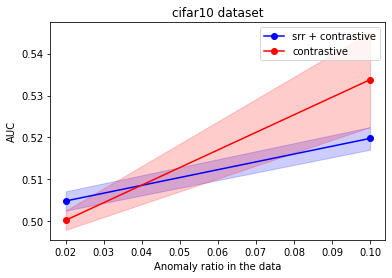

In [ ]:
avrg_auc, sd_auc = [np.mean(seed) for seed in auc_score], [np.std(seed) for seed in auc_score]
avrg_auc_srr, sd_auc_srr = [np.mean(seed) for seed in auc_score_srr], [np.std(seed) for seed in auc_score_srr]
ss_type_srr = 'srr + ' + ss_type
plt.plot(abn_rates, avrg_auc_srr, '-or', color='blue', label = ss_type_srr)
plt.fill_between(abn_rates, [avrg_auc_srr[i] - sd_auc_srr[i] for i in range(len(sd_auc_srr))], [avrg_auc_srr[i] + sd_auc_srr[i] for i in range(len(sd_auc_srr))],
                 color='blue', alpha=0.2)

plt.plot(abn_rates, avrg_auc, '-or', color='red', label = ss_type)
plt.fill_between(abn_rates, [avrg_auc[i] - sd_auc[i] for i in range(len(sd_auc))], [avrg_auc[i] + sd_auc[i] for i in range(len(sd_auc))],
                 color='red', alpha=0.2)
plt.legend()
plt.xlabel("Anomaly ratio in the data")
plt.ylabel("AUC")
title = dataset + " dataset"
plt.title(title)

plt.show()


# SRR

In [ ]:
#defining the model and the loss
ss_type = 'contrastive'
if ss_type == 'rotation':
  rotations_number = 4
  model = resnet18(pretrained=False, num_classes=rotations_number).to(device)
  feature_extractor = nn.Sequential(*list(model.children())[:-1])
  model.feature_extractor = feature_extractor
  criterion = nn.CrossEntropyLoss().to(device)
else:
  model = PreModel(hidden_dim=512).to(device)
  #criterion = SupConLoss().to(device)
  criterion = NT_Xent().to(device)

In [ ]:
# Setting the optimiser
optimizer = optim.Adam(model.parameters(),
                       lr=1e-4,
                       betas=(0.9, 0.999),
                       weight_decay=5e-4)

In [ ]:
#Run the algorithms
k=4
th = 1 - (2*abnormal_rate)

refined_data_idx, occ, model = SSR(trainset_tuple, k, th, model, nepochs=1, verbose=0, occ_type='svm')

--------------------------------------------------------------------
Epoch: 1 self-supervised contrastive loss: 0.6157949972832792


In [ ]:
if ss_type == 'rotation':
  data_to_train = extract_features(trainset_tuple, model)
else:
  data_to_train = extract_features_contrastive(trainset_tuple, model)

if ss_type == 'rotation':
  data_to_test = extract_features(testset_tuple, model)
else:
  data_to_test = extract_features_contrastive(testset_tuple, model)



scores_train = -occ.score_samples(data_to_train)
scores_test = -occ.score_samples(data_to_test)


ytrain = []
ytest = []
for i in range(len(trainset_tuple)):
    ytrain.append(trainset_tuple[i][1])

for i in range(len(testset_tuple)):
    ytest.append(testset_tuple[i][1])

final_th = np.quantile(scores_train, th)
pred_train = [int(preds) for preds in scores_train > final_th]
pred_test = [int(preds) for preds in scores_test > final_th]


print('train')
print("F1: {:.2f}  AUC: {:.2f}  Average precision: {:.2f}".format(f1(pred_train, trainset_tuple), auc(pred_train, trainset_tuple), average_precision(pred_train, trainset_tuple)))
print('test')
print("F1: {:.2f}  AUC: {:.2f}  Average precision: {:.2f}".format(f1(pred_test, testset_tuple), auc(pred_test, testset_tuple), average_precision(pred_test, testset_tuple)))

train
F1: 0.12  AUC: 0.50  Average precision: 0.09
test
F1: 0.11  AUC: 0.48  Average precision: 0.09


# Training without SSR

In [ ]:
#defining the model and the loss
ss_type = ''
if ss_type == 'rotation':
  rotations_number = 4
  model = resnet18(pretrained=False).to(device)
  features = model.fc.in_features
  model.fc = nn.Linear(in_features=features, out_features=rotations_number, bias=True).to(device)
  feature_extractor = nn.Sequential(*list(model.children())[:-1])
  model.feature_extractor = feature_extractor
  criterion = nn.CrossEntropyLoss().to(device)
else:
  model = PreModel(hidden_dim=512).to(device)
  #criterion = SupConLoss().to(device)
  criterion = NT_Xent().to(device)

# Setting the optimiser
optimizer = optim.Adam(model.parameters(),
                       lr=3e-4,
                       betas=(0.9, 0.999),
                       weight_decay=5e-4)

In [ ]:
th = 1 - (2*abnormal_rate)
best_loss = 10000
es=0
for epoch in range(1):
  if ss_type == 'rotation':
    act_loss = train(model, trainset_tuple, criterion, optimizer, epoch)
  else:
    act_loss = train_contrastive(model, trainset_tuple, criterion, optimizer, epoch)

  es+=1
  if act_loss < best_loss:
    best_loss = act_loss
    es=0
  if es>50:
    break
  # occ = GaussianMixture(n_components=1, covariance_type="tied", reg_covar=1e-03)
  # if ss_type == 'rotation':
  #   data_to_train = extract_features(trainset_tuple, model)
  # else:
  #   data_to_train = extract_features_contrastive(trainset_tuple, model)
  # occ.fit(data_to_train)

  # #Evaluate on train set
  # evaluate(model, occ, trainset_tuple)
  print('-----------------------------------------------')

Epoch: 1 self-supervised contrastive loss: 0.8594699968882608
-----------------------------------------------


In [ ]:
if dataset == 'catdog':
  testset = datasets.ImageFolder('Cat_Dog_data/test', transform=catDog_transforms)
elif dataset == 'fmnist':
  testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=transform)
else:
  testset = datasets.CIFAR10(root='data/', download=True, transform=transform)

testset_tuple = preprocess_dataset(testset.data, testset.targets, len(testset.classes), abnormal_rate=abnormal_rate)

Files already downloaded and verified


In [ ]:

if ss_type == 'rotation':
  data_to_train = extract_features(trainset_tuple, model)
else:
  data_to_train = extract_features_contrastive(trainset_tuple, model)

if ss_type == 'rotation':
  data_to_test = extract_features(testset_tuple, model)
else:
  data_to_test = extract_features_contrastive(testset_tuple, model)



In [ ]:
clf = OneClassSVM(kernel='rbf', gamma=.01).fit(data_to_train)

In [ ]:
scores_train = -clf.score_samples(data_to_train)
scores_test = -clf.score_samples(data_to_test)

In [ ]:

ytrain = []
ytest = []
for i in range(len(trainset_tuple)):
    ytrain.append(trainset_tuple[i][1])

for i in range(len(testset_tuple)):
    ytest.append(testset_tuple[i][1])


In [ ]:
final_th = np.quantile(scores_train, th)
pred_train = [int(preds) for preds in scores_train > final_th]
pred_test = [int(preds) for preds in scores_test > final_th]


final_th

-285.7750252968998

In [ ]:
print('train')
print("F1: {:.2f}  AUC: {:.2f}  Average precision: {:.2f}".format(f1(pred_train, trainset_tuple), auc(pred_train, trainset_tuple), average_precision(pred_train, trainset_tuple)))
print('test')
print("F1: {:.2f}  AUC: {:.2f}  Average precision: {:.2f}".format(f1(pred_test, testset_tuple), auc(pred_test, testset_tuple), average_precision(pred_test, testset_tuple)))

train
F1: 0.13  AUC: 0.50  Average precision: 0.09
test
F1: 0.11  AUC: 0.49  Average precision: 0.09
